# Problem setup

## Imporst and loaing an image of Betelgeuse

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

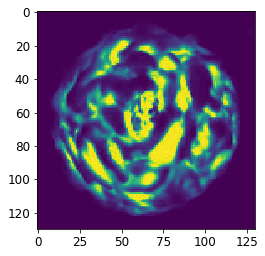

In [24]:
# Betelgeuse image from https://arxiv.org/abs/1003.1407
im_orig = matplotlib.image.imread("betelgeuse_chiavassa_et_al_2010_700nm.png")

im_sampling = 2 #makes the code run faster but shouldn't be too low to avoid undersampling
im_sampled = im_orig[::im_sampling,::im_sampling,0]
pixel_scale_mas = 0.2*im_sampling #approximate scale of the image
pixel_scale_rad = pixel_scale_mas*4.84814e-9

lam0 = 700e-9 #wavelength in m
dlam = 1e-8 #bandwidth in m

intensity_scale = 3.5e5 #erg cm^-2 s^-1 A^-1 as given in Chiavassa et al. 2010
intensity_scale_mks = intensity_scale*1e-8*1e4*1e10

plt.imshow(im_sampled)

## Padding the image, defining its coordinates and FOV

In [25]:
N_pix = 2*im_sampled.shape[0] #pad the image
assert(im_sampled.shape[0] == im_sampled.shape[1])
im_padded = np.pad(im_sampled, ((0,N_pix-im_sampled.shape[0]), (0,N_pix-im_sampled.shape[1])))

Theta = pixel_scale_rad*N_pix #field of view (FOV)
M,N = np.meshgrid(np.arange(0,N_pix), np.arange(0,N_pix))

mn_to_uv_scale = lam0/Theta #how angles in the FOV map to coordinates in the uv plane

## uv-plabe coverage with one semi-cicle per orbit (per https://arxiv.org/abs/1912.02350)

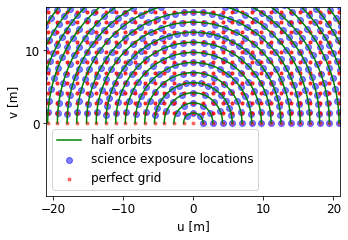

In [26]:
plt.figure(figsize=(5,3.5))
plt.rcParams.update({"font.size": 12})
M_modes = []
N_modes = []
MN_hypot = np.hypot(M - N_pix//2, N - N_pix//2)
for r in range(1,int(B_max/mn_to_uv_scale)+1): #iterate of circles/orbits
    r_exposures = np.sum(np.round(MN_hypot) == r)//2 #compute the number of exposure ot match the number of Fourier modes closes to the semi-circle
    M_modes.append(r*np.cos(np.arange(0, np.pi, np.pi/r_exposures)))
    N_modes.append(r*np.sin(np.arange(0, np.pi, np.pi/r_exposures)))
    label = "half orbits" if r==1 else None
    plt.plot(r*mn_to_uv_scale*np.cos(np.linspace(0,np.pi,100)), r*mn_to_uv_scale*np.sin(np.linspace(0,np.pi,100)), color="g", label=label)

u = np.concatenate(M_modes)*mn_to_uv_scale
v = np.concatenate(N_modes)*mn_to_uv_scale
K = len(u) #total number of exposures

plt.scatter(u, v, color="b", alpha=0.5, label="science exposure locations")
plt.scatter((M - N_pix//2)*mn_to_uv_scale, np.abs(N - N_pix//2)*mn_to_uv_scale, marker=".", color="r", alpha=0.5, label="perfect grid")
plt.yticks([0,10,20])
plt.ylim(-10,16)
plt.xlim(-21,21)
plt.xticks([-20,-10,0,10,20])
plt.xlabel("u [m]")
plt.ylabel("v [m]")
plt.legend()
plt.tight_layout()

## Collector properties and flux

In [27]:
B_max = 40 #maximum baseline in m
tau_sci = 20 #exposure time in s
d_collector = 0.057 #collector diameter in m
h = 6.626e-34 
c = 3e8
T = 5400 #orbital period in s
theta = 1e-7 # parasitic acceleration in m/s^2*Hz^-0.5

J = intensity_scale_mks/np.max(im_padded)*im_padded #image in units of photons/s/m^3
I = np.sum(J)*pixel_scale_rad**2*(np.pi/4)*d_collector**2*lam0*dlam/(8*h*c) #total flux in photons/s

## Define linear transform (Xi) from image (J) to complex visibility (nu_complex)

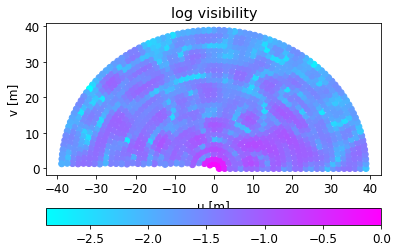

In [28]:
Xi_scaling = pixel_scale_rad**2*(np.pi/4)*d_collector**2*lam0*dlam/(8*h*c*I) #scaling such that the visibilities are <= 1

def get_Xi_rows(u, v, lam):
    modes = 2*np.pi*pixel_scale_rad/lam*np.array(list(zip(u, v)))
    
    yield Xi_scaling*np.ones(N_pix**2)
    for m_,n_ in modes:
        yield Xi_scaling*np.cos((m_*M + n_*N).ravel())
        
    for m_,n_ in modes:
        yield Xi_scaling*np.sin((m_*M + n_*N).ravel())

Xi = np.stack(list(get_Xi_rows(u, v, lam0)))
nu_complex = Xi.dot(J.ravel())

nu = np.hypot(nu_complex[1:K+1], nu_complex[K+1:])
plt.scatter(u, v, c=np.log10(nu), cmap="cool", vmax=0)
plt.title("log visibility")
plt.xlabel("u [m]")
plt.ylabel("v [m]")
plt.colorbar(orientation="horizontal")

## Compute the pseudo-inverse of Xi and show te image projection on the row-span of Xi

(-0.5, 129.5, 129.5, -0.5)

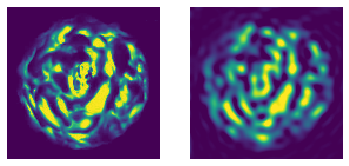

In [36]:
Xi_pinv = Xi.T.dot(np.linalg.inv(Xi.dot(Xi.T)))
J_proj = Xi_pinv.dot(nu_complex)
plt.subplot(121)
plt.imshow(J.reshape((N_pix, N_pix))[:N_pix//2,:N_pix//2], vmin=0, vmax=np.max(J))
plt.axis("off")
plt.subplot(122)
plt.imshow(J_proj.reshape((N_pix, N_pix))[:N_pix//2,:N_pix//2], vmin=0, vmax=np.max(J))
plt.axis("off")

## Add visibility biases and noise

###  Bias due to spaceraft orbital motion (second derivative w.r.t. rotation in the uv plane)

In [30]:
rot_angle = 1e-3 #use a small angle to compute the finite difference derivative w.r.t. angle
rotated_u = np.cos(rot_angle)*u - np.sin(rot_angle)*v
rotated_v = np.sin(rot_angle)*u + np.cos(rot_angle)*v
counter_rotated_u = np.cos(rot_angle)*u + np.sin(rot_angle)*v
counter_rotated_v = -np.sin(rot_angle)*u + np.cos(rot_angle)*v

rotated_nu_complex = np.array(list(row.dot(J.ravel()) for row in get_Xi_rows(rotated_u, rotated_v, lam0)))
counter_rotated_nu_complex = np.array(list(row.dot(J.ravel()) for row in get_Xi_rows(counter_rotated_u, counter_rotated_v, lam0)))

rotated_nu = np.hypot(rotated_nu_complex[1:K+1], rotated_nu_complex[K+1:])
counter_rotated_nu = np.hypot(counter_rotated_nu_complex[1:K+1], counter_rotated_nu_complex[K+1:])

d2nu_drot_angle2 = (rotated_nu - 2*nu + counter_rotated_nu)/rot_angle**2

### Spectral smearing

In [31]:
plus_shifted_nu_complex = np.array(list(row.dot(J.ravel()) for row in get_Xi_rows(u, v, lam0+dlam/2)))
minus_shifted_nu_complex = np.array(list(row.dot(J.ravel()) for row in get_Xi_rows(u, v, lam0-dlam/2)))
lam_avg_nu_complex = (plus_shifted_nu_complex + nu_complex + minus_shifted_nu_complex)/3
lam_avg_nu = np.hypot(lam_avg_nu_complex[1:K+1], lam_avg_nu_complex[K+1:])

### Bias due to fringe tracking

In [32]:
var_phi = (4*theta**2/lam0**2/I**3/nu**6)**0.25

### Combine all biases and "add" shot noise

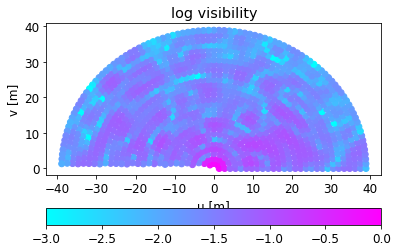

In [35]:
nu_mean = lam_avg_nu + 1/24*d2nu_drot_angle2*(2*np.pi/T*tau_sci)**2 - 0.5*var_phi*nu
nu_std = np.sqrt(1/(tau_sci*I))*np.ones(nu.shape)
#The true noise is a difference of Poisson distribution. Here we simplify by using a normal distribution but not allowing negative visibility values.
nu_meas = np.random.normal(nu_mean, nu_std)
nu_meas = nu_meas*(nu_meas > 0)

plt.scatter(u, v, c=np.log10(nu_meas), cmap="cool", vmax=0, vmin=-3)
plt.title("log visibility")
plt.xlabel("u [m]")
plt.ylabel("v [m]")
plt.colorbar(orientation="horizontal")

# Problem solution

## Define object support and initialize radom phases

In [39]:
rho = 1.5
S0 = 1.0*((M - N_pix/2)**2 + (N - N_pix/2)**2 < (rho/4*N_pix)**2).ravel()
phi_hat = 2*np.pi*np.random.random(nu_meas.shape)
nu_complex_hat = np.concatenate([[1], nu_meas*np.cos(phi_hat), nu_meas*np.sin(phi_hat)])
J_hat = Xi_pinv.dot(nu_complex_hat)

## Define the Hybrid Input-Output Iteration

In [41]:
beta = 0.5
def hio_iteration(J_hat):
    #compute estimates of pse of complex visibilities from current image estimate
    nu_complex_hat = Xi.dot(J_hat)
    phi_hat = np.arctan2(nu_complex_hat[K+1:], nu_complex_hat[1:K+1])
    
    #combined measured visibilities with estimated phase
    nu_complex_hat_tag = np.concatenate([[1], nu_meas*np.cos(phi_hat), nu_meas*np.sin(phi_hat)])
    
    #get new image
    J_hat_tag = Xi_pinv.dot(nu_complex_hat_tag)
    
    #HIO step
    S = 1.0*(J_hat_tag > 0)*S0 #region where image satisfies support and non-negative constraints
    J_hat = J_hat_tag*S + (J_hat - beta*J_hat_tag)*(1 - S)
    
    return J_hat_tag, J_hat

## Run the HIO iterations

In [44]:
N_iter = 10000
#keep track of cost and best cost up to a given iteration
best_costs = [np.inf]
costs = []
for _ in range(N_iter):
    J_hat_tag, J_hat = hio_iteration(J_hat)
    
    #cost of violting constraints
    costs.append(np.sum(np.abs(J_hat_tag)*(1 - S0) - (J_hat_tag<0)*S0*J_hat_tag))
    best_costs.append(min(best_costs[-1], costs[-1]))
    if costs[-1] == best_costs[-1]:
        best_J_hat = J_hat_tag
        
best_costs = best_costs[1:]

## Translate output image and possibly rotate by 180 degrees to compute the reconstruction error

In [47]:
J_sub = J[:im_sampled.shape[0],:im_sampled.shape[1]] #the original image and the output image are both padded; this selects just part of the image
best_tuple = None
for J_hat in (best_J_hat.reshape(J.shape), best_J_hat.reshape(J.shape)[::-1,::-1]): #try the output image as is and rotated by 180 degrees
    for o1 in range(J.shape[0] - im_sampled.shape[0]): #shift in y axis
        for o2 in range(J.shape[1] - im_sampled.shape[1]): #shift in x axis
            J_hat_sub = J_hat[o1:o1+im_sampled.shape[0],o2:o2+im_sampled.shape[1]] #the original image and the output imae are both padded; this selects just part of the image
            err = np.sum((J_sub - J_hat_sub)**2) #compute error
            if best_tuple is None or best_tuple[0] > err: #store the best image and the corresponding shift
                best_tuple = (err, o1, o2, J_hat_sub)
                
err, _, _, J_hat_sub = best_tuple
print(np.sqrt(err/np.sum(J_sub**2)))

0.3851516964802416


## Plot

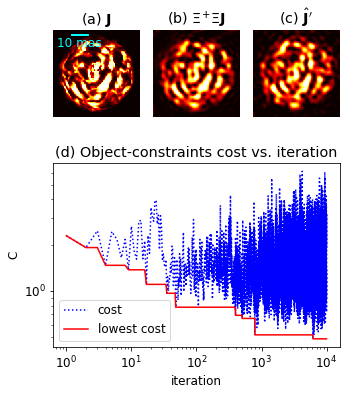

In [50]:
plt.figure(figsize=(5,6))
plt.rcParams.update({"font.size": 12})
ax = plt.subplot(2,3,1)
plt.imshow(J[:im_sampled.shape[0],:im_sampled.shape[0]], vmin=0, vmax=np.max(J), cmap="hot")
scalebar = AnchoredSizeBar(ax.transData,
                           10/pixel_scale_mas, "10 mas", "upper left", 
                           pad=0.2,
                           color="#00ffff",
                           frameon=False,
                           size_vertical=1)

ax.add_artist(scalebar)
plt.axis("off")
plt.title(r"(a) $\mathbf{J}$")
plt.subplot(2,3,2)
plt.axis("off")
plt.title(r"(b) $\Xi^{+} \Xi \mathbf{J}$")
plt.imshow(J_proj.reshape(J.shape)[:im_sampled.shape[0],:im_sampled.shape[1]], vmin=0, vmax=np.max(J), cmap="hot")
plt.subplot(2,3,3)
plt.axis("off")
plt.title(r"(c) $\hat{\mathbf{J}}'$")
plt.imshow(J_hat_sub, vmin=0, vmax=np.max(J), cmap="hot")
plt.subplot(2,1,2)
plt.plot(np.arange(1, len(costs)+1), np.array(costs)*Xi_scaling, color="b", linestyle=":", label="cost")
plt.plot(np.arange(1, len(costs)+1), np.array(best_costs)*Xi_scaling, color="r", label="lowest cost")
plt.xscale("log")
plt.yscale("log")
plt.title("(d) Object-constraints cost vs. iteration")
plt.xlabel("iteration")
plt.ylabel("C")
plt.legend(loc=3)
plt.tight_layout()
#plt.savefig("../40m_results_wo_lgs.pdf")